In [1]:
import torch
from sklearn.manifold import TSNE
import numpy as np
import timm
from src.dataset.augmentations import get_gan_validation_augmentations
from src.dataset.GANDataset import dataset2
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
from src.model import Model
from torch.utils.data import Dataset, DataLoader
import cv2
from albumentations.pytorch import ToTensorV2

/home/dogoulis/anaconda3/envs/sucocbt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# init model
config = {"projector":[2048, 8192, 8192, 8192]}
model = Model(config=config)
#model.load_state_dict(torch.load('./checkpoints/model/best-ckpt.pt'))

# DATASET

dataset needs to be in the mentioned form:

columns = ["image_path", "label", "label_2"]

1) image_path = path for the given image
2) label = the label of the image (real/fake)
3) the encoded label for each deepfake category or real category of the image. \
e.g. GAN DATASET: \
0 = real_ffhq \
1 = real_afhq \
2 = fake_ffhq \
. \
. \
. 

In [3]:
class dataset_v2(Dataset):

    def __init__(self, dataset_path, transforms):
        self.dataset = pd.read_csv(dataset_path)
        self.imgs = self.dataset.image_path.values
        self.labels = self.dataset.label.values
        self.id = self.dataset.label_2
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        try:
            image = cv2.imread(self.imgs[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print(self.imgs[idx])
            idx += 1
            image = cv2.imread(self.imgs[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.labels[idx]
        id = self.id[idx]
        if self.transforms:
            tr_img = self.transforms(image=image)
            image = tr_img['image']
        else:
            image = ToTensorV2(image)
        label = torch.tensor(label).float()

        return image, label, id

In [4]:
@torch.no_grad()
def extract_features(model, dataloader):
    model.eval()

    vectors, id = [], []

    for  x, _, image_id in tqdm(dataloader):
        
        #x = x.to('cuda:0')

        # first get the forward features
        vector = model(x)
        vectors.append(vector.detach().cpu().numpy())

        # then append image_id on array
        id.append(image_id)

    vectors = np.array(vectors)
    id = np.array(id)

    return vectors, id

In [5]:
# init augmentations
augs = get_gan_validation_augmentations()
# init test_dir
test_dir = '/home/dogoulis/WORKSPACE/gan-prediction/data/evaluation/mixed_dataset_viz.csv'

In [6]:
test_dataset = dataset_v2(test_dir, transforms=augs)
test_dataloader = DataLoader(test_dataset, num_workers=8, batch_size=1, shuffle=False)

In [7]:
vectors, id = extract_features(model, dataloader=test_dataloader)

100%|██████████| 6000/6000 [02:43<00:00, 36.75it/s]


# Reshaping:

In [8]:
len_data = len(test_dataset)

vectors = np.reshape(vectors, (len_data, 2048))
id = np.reshape(id, (len_data, 1))

# Getting tsne embs

In [9]:
# init tsne object:
tsne = TSNE(n_components=2, random_state=42)

In [10]:
out_emb = tsne.fit_transform(vectors)

/home/dogoulis/anaconda3/envs/sucocbt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dogoulis/anaconda3/envs/sucocbt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Formating:

In [11]:
encoded_series = pd.Series(np.reshape(id, (len_data,)))
tsne_df = pd.DataFrame(out_emb, columns=['x1', 'x2'])
tsne_df = pd.concat([tsne_df,encoded_series], axis=1)
tsne_df.columns = ['x1', 'x2', 'encoded_label']

# Visualization

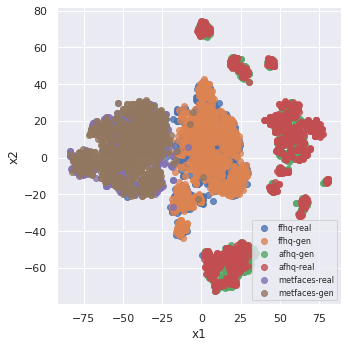

In [12]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,8)}) 
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x1", y="x2", data=tsne_df, fit_reg=False, hue='encoded_label', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right', prop={'size': 8})

plt.show()